In [365]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-log-time-series") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [366]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-log-time-series>

In [367]:
from pathlib import Path

global_data_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/")
global_data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log')

In [368]:
data_dir = global_data_dir / "focused"
data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused')

In [369]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [370]:
def paths_jsonl(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    yield from base_path.glob("*/*.jsonl.gz")

In [371]:
def paths_warc(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    for path in base_path.glob("*/*"):
        if path.is_dir():
            yield path

In [372]:
from gzip import GzipFile


def count_jsonl(path: Path) -> int:
    print(f"Count JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as file:
            return sum(1 for _ in file)
    except:
        return 0

In [373]:
from json import loads, JSONDecodeError
from typing import Iterator

def read_jsonl(path: Path) -> Iterator:
    print(f"Read JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as gzip_file:
            for line in gzip_file:
                try:
                    url = loads(line)
                except JSONDecodeError:
                    continue
                yield url
    except:
        return 

In [374]:
from json import loads, JSONDecodeError
from typing import Iterator

def read_warc_header(path: Path) -> Iterator:
    for warc_child_path in path.iterdir():
        if warc_child_path.name.startswith("."):
            continue
        try:
            stream = FileStream(str(warc_child_path.absolute()))
            records = ArchiveIterator(
                stream,
                record_types=WarcRecordType.response,
                parse_http=False,
            )
            for record in tqdm(records, desc="Read WARC headers"):
                record: WarcRecord
                offset = record.stream_pos
                record_url_header = record.headers["Archived-URL"]
                try:
                    record_url = loads(record_url_header)
                except JSONDecodeError:
                    print(f"Could not read {record_url_header} at {path}.")
                    continue
                yield record_url
        except:
            print(f"Could not read WARC file at {warc_child_path}.")
            continue

In [376]:
counts_urls = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
    .keyBy(lambda date: (date.year, date.month, date.day))\
    .countByKey()
df_urls = DataFrame([
    {
        "year": year,
        "month": month,
        "day": day,
        "count": count,
    }
    for (year, month, day), count in counts_urls.items()
])
df_urls["variant"] = "urls"
df_urls

,year,month,day,count,variant
0,2019,10,29,317156,urls
1,2019,10,28,170420,urls
2,2019,10,26,216547,urls
3,2019,10,27,175534,urls
4,2019,10,30,308205,urls
...,...,...,...,...,...
8539,1998,5,24,1,urls
8540,1999,11,21,29,urls
8541,1998,2,19,457,urls
8542,2000,3,26,1,urls


In [377]:
df_urls["count"].sum()

1009735130

In [378]:
counts_queries = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
    .keyBy(lambda date: (date.year, date.month, date.day))\
    .countByKey()
df_queries = DataFrame([
    {
        "year": year,
        "month": month,
        "day": day,
        "count": count,
    }
    for (year, month, day), count in counts_queries.items()
])
df_queries["variant"] = "queries"
df_queries

,year,month,day,count,variant
0,2020,7,21,72837,queries
1,2021,3,4,202314,queries
2,2019,12,10,96812,queries
3,2021,1,9,94049,queries
4,2020,6,8,114609,queries
...,...,...,...,...,...
8141,2001,4,5,3,queries
8142,2006,8,5,432,queries
8143,2007,7,24,15,queries
8144,2007,7,29,2,queries


In [379]:
df_queries["count"].sum()

356421234

In [403]:
counts_unique_queries = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .sortBy(lambda query: query["timestamp"])\
    .keyBy(lambda query: query["query"])\
    .reduceByKey(lambda query1, query2: query1 if datetime.fromtimestamp(query1["timestamp"]) <= datetime.fromtimestamp(query2["timestamp"]) else query2)\
    .values()\
    .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
    .keyBy(lambda date: (date.year, date.month, date.day))\
    .countByKey()
df_queries_uniq = DataFrame([
    {
        "year": year,
        "month": month,
        "day": day,
        "count": count,
    }
    for (year, month, day), count in counts_unique_queries.items()
])
df_queries_uniq["variant"] = "unique queries"
df_queries_uniq

,year,month,day,count,variant
0,2006,2,16,2261,unique queries
1,2005,3,11,2847,unique queries
2,2006,2,17,1731,unique queries
3,2006,2,18,1629,unique queries
4,2003,7,5,505,unique queries
...,...,...,...,...,...
7969,2003,7,26,1,unique queries
7970,2003,3,25,1,unique queries
7971,2001,1,23,1,unique queries
7972,2006,7,30,1,unique queries


In [404]:
df_queries_uniq["count"].sum()

64544345

In [405]:
counts_serps = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
    .keyBy(lambda date: (date.year, date.month, date.day))\
    .countByKey()
df_serps = DataFrame([
    {
        "year": year,
        "month": month,
        "day": day,
        "count": count,
    }
    for (year, month, day), count in counts_serps.items()
])
df_serps["variant"] = "SERPs"
df_serps

,year,month,day,count,variant
0,2017,3,29,231,SERPs
1,2017,3,8,1317,SERPs
2,2016,9,3,48,SERPs
3,2021,12,17,4177,SERPs
4,2012,11,18,28,SERPs
...,...,...,...,...,...
6656,2010,9,20,51,SERPs
6657,2009,7,2,13,SERPs
6658,2005,2,13,1,SERPs
6659,2006,1,29,1,SERPs


In [406]:
df_serps["count"].sum()

5482954

In [407]:
counts_results = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .filter(lambda serp: serp["results"] is not None)\
    .flatMap(lambda serp: serp["results"])\
    .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
    .keyBy(lambda date: (date.year, date.month, date.day))\
    .countByKey()
df_documents = DataFrame([
    {
        "year": year,
        "month": month,
        "day": day,
        "count": count,
    }
    for (year, month, day), count in counts_results.items()
])
df_documents["variant"] = "documents"
df_documents

,year,month,day,count,variant
0,2021,12,17,35411,documents
1,2012,11,18,569,documents
2,2021,12,18,28109,documents
3,2008,6,7,129,documents
4,2015,4,9,777,documents
...,...,...,...,...,...
5727,2000,9,25,20,documents
5728,2001,3,30,20,documents
5729,2006,1,29,10,documents
5730,2006,2,6,10,documents


In [408]:
df_documents["count"].sum()

58282774

In [409]:
from pandas import concat

df = concat([
    df_urls,
    df_queries,
    df_queries_uniq,
    df_serps,
    df_documents,
])
df

,year,month,day,count,variant
0,2019,10,29,317156,urls
1,2019,10,28,170420,urls
2,2019,10,26,216547,urls
3,2019,10,27,175534,urls
4,2019,10,30,308205,urls
...,...,...,...,...,...
5727,2000,9,25,20,documents
5728,2001,3,30,20,documents
5729,2006,1,29,10,documents
5730,2006,2,6,10,documents


In [410]:
from math import floor, ceil

end = ceil(df["year"].max())
start = floor(df["year"].min())

In [411]:
df_plot = df.copy()
df_plot["year"] = df_plot["year"] + ((df_plot["month"] - 1) / 12) + ((df_plot["day"] - 1) / 365)
del df_plot["month"]
df_plot.groupby(["year", "variant"]).sum()
df_plot

,year,day,count,variant
0,2019.826712,29,317156,urls
1,2019.823973,28,170420,urls
2,2019.818493,26,216547,urls
3,2019.821233,27,175534,urls
4,2019.829452,30,308205,urls
...,...,...,...,...
5727,2000.732420,25,20,documents
5728,2001.246119,30,20,documents
5729,2006.076712,29,10,documents
5730,2006.097032,6,10,documents


<Figure size 640x480 with 0 Axes>

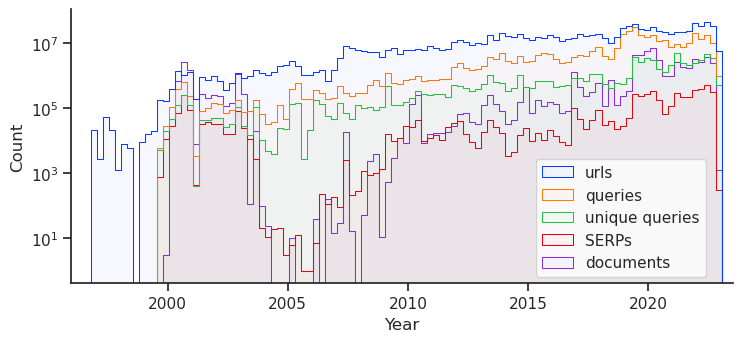

In [420]:
from seaborn import histplot, FacetGrid, color_palette, kdeplot, displot, set_theme, set_style, move_legend
from matplotlib.pyplot import tight_layout, axhline

width = 7.5
aspect = 2
set_theme()
tight_layout()
set_style("ticks")
plot = displot(
    data=df_plot,
    kind="hist",
    x="year",
    weights="count",
    hue="variant",
    palette="bright",
    element="step",
    linewidth=0.75,
    alpha=0.03,
    binwidth=1/12*3,
    aspect=aspect,
    height=width/aspect,
)
plot.set(
    xlim=(start, end+1.5),
)
plot.set_axis_labels("Year", "Count")
# plot.set_axis_labels("", "")
move_legend(
    plot,
    title="",
    loc="lower right",
    bbox_to_anchor=(0.765, 0.175),
    frameon=True,
)
plot.set(yscale="log")
# plot.despine(left=True)
plot.savefig("figures/plot-time-series-types.pdf")
plot.savefig("figures/plot-time-series-types.png")
plot